# Running a Dynamical Decoupling Sequence on IBM Q

Q-CTRL Open Controls provides easy-to-use methods to construct Dynamical Decoupling Sequences (DDS) according to well-known dynamical decoupling schemes. This is described in the [creating a DDS notebook](creating_a_dds.ipynb). Here we show how a DDS from Q-CTRL Open Controls can be exported to a Qiskit circuit to run on an IBM Q device. We also show how a DDS can decrease the number of errors, when executing a quantum circuit on a real quantum computer, by extending the coherence time.

Note: To run the DDS on a real device, you need to have an IBM Q account and acquire an API token. [Sign Up](https://quantumexperience.ng.bluemix.net/qx/login) if you have not already done so. Additionally, you will need to have the Qiskit library installed. Consult [Installing Qiskit](https://qiskit.org/documentation/install.html) for more information.

## Imports

In [1]:
#General

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#Q-CTRL Open Controls
from qctrlopencontrols import new_predefined_dds, convert_dds_to_quantum_circuit

#Qiskit
##To define a backend (simulated or real)
from qiskit import execute, BasicAer

##To plot the outcome
from qiskit.tools.visualization import plot_histogram

## To handle account information,find a suitable device and monitor a job
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

## Running a DDS on a Qiskit Simulator

This section demonstrates how a DDS can be prepared and a corresponding Qiskit circuit made and executed on a Qiskit simulator.

Q-CTRL Open Controls defines a DDS as a set of instantaneous unitary operations performed at specific offset times, see the [technical documentation](https://docs.q-ctrl.com/control-library#dynamical-decoupling-sequences) for mathematical details.

Qiskit implements quantum computation through a series of [gates in a quantum circuit](https://qiskit.org/documentation/getting_started.html#circuit-basics). How these gates are physically implemented will depend on the device that it is run on.

On IBM Q devices, individual qubit rotations are completed using two basis elements. $Z$ rotations are performed with (almost) instantaneous clock shifts and $Y$ rotations are performed with microwave pulses over a fixed time. All single qubit gates are a combination of these two.

If a user wants to add pauses (in time) during a computation they can use identity gates and barriers. The barriers ensure that the circuit is not simplified before execution on the machine. Both identity gates and $X$ or $Y$ rotation gates take a fixed time (`gate_time`).

Converting a DDS into a Qiskit circuit is an approximate process where the instantaneous unitaries are replaced with finite duration gates and the pauses in-between unitaries are replaced with the closest integer number of identity gates. The exact algorithm used to make this approximation is documented in the [source code](https://github.com/qctrl/python-open-controls/blob/master/qctrlopencontrols/qiskit/quantum_circuit.py).

In this example we will define a Quadratic DDS and convert it into a circuit that we can later run on a simulator and on a real device. See [creating_a_DDS.ipynb](creating_a_DDS.ipynb) to see how other sequences can be created. We also create a Ramsey DDS of the same duration to compare as a benchmark. For both the sequences, we add a $X_{\pi/2}$ rotation on either end of the sequence.

### Preparing the Sequences

In [2]:
## Quadratic sequence, total duration: 20us
quadratic_sequence = new_predefined_dds(
    scheme='quadratic',
    duration=20e-6, 
    number_inner_offsets=2,
    number_outer_offsets=2,
    pre_post_rotation=True,
    name='Quadratic sequence')

# Ramsey sequence, total duration: 20us
ramsey_sequence = new_predefined_dds(
    scheme='Ramsey',
    duration=20e-6,
    pre_post_rotation=True,
    name='Ramsey sequence')

print(quadratic_sequence)
print(ramsey_sequence)

Quadratic sequence:
Duration = 2e-05
Offsets = [0.0,0.06249999999999998,0.18749999999999994,0.24999999999999994,0.37499999999999994,0.6249999999999999,0.7499999999999999,0.8124999999999999,0.9375,1.0] x 2e-05
Rabi Rotations = [0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.5] x pi
Azimuthal Angles = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0] x pi
Detuning Rotations = [0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0] x pi
Ramsey sequence:
Duration = 2e-05
Offsets = [0.0,1.0] x 2e-05
Rabi Rotations = [0.5,0.5] x pi
Azimuthal Angles = [0.0,0.0] x pi
Detuning Rotations = [0.0,0.0] x pi


### Constructing the Circuit Using Q-CTRL Open Controls

To construct a `QuantumCircuit` from a DDS, we need to provide the DDS (`dynamic_decoupling_sequence`). You can also provide a list (`target_qubits`) to indicate qubit indices on which the DDS will be applied. `gate_time` is the delay (in seconds) introduced by each of the `identity` gates. If measurement is required, use `add_measurement=True`. Optionally you can provide a name to the circuit (`circuit_name`).

See the [source code](https://github.com/qctrl/python-open-controls/blob/master/qctrlopencontrols/qiskit/quantum_circuit.py) for more information and other parameters that may be useful.

In this example, we will use $0$th qubit and specify the `gate_time` to be $0.2$ $\mu$s. For a quadratic DDS, we will use default $X_{\pi/2}$ rotation as the pre-post gate (Ramsey DDS has this rotation as part of the sequence definition). Both the DDS will require a measurement operation.

In [3]:
## Prepare the Qiskit related parameters
'''
target_qubits : list
    A list of integers specifying the target qubits within the set of qubit registers
'''
target_qubits = [0]

'''
gate_time : float
    Time delay (in seconds) introduced by identity gate
'''
gate_time = 0.4e-6

'''
add_measurement : bool
    Indicates if the circuit requires a measurement step.
    Required for 'qasm_simulator' and real device backends
'''
add_measurement = True

'''
circuit_name : str
    An optional string as a name to the circuit
'''
circuit_name = 'quadratic-sequence-circuit'

'''
algorithm : str
    An optional string to specify the algorithm used to place identity gates.
    Can be 'instant unitary' or 'fixed duration unitary'. See source code
    documentation for more details.
'''
algorithm = 'instant unitary'


## convert the quadratic sequence to QuantumCircuit

quadratic_quantum_circuit = convert_dds_to_quantum_circuit(
    dynamic_decoupling_sequence=quadratic_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
    circuit_name=circuit_name,
    algorithm=algorithm
)

## convert the ramsey sequence to QuantumCircuit
circuit_name = 'ramsey-sequence-circuit'
ramsey_quantum_circuit = convert_dds_to_quantum_circuit(
    dynamic_decoupling_sequence=ramsey_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
    circuit_name=circuit_name,
    algorithm=algorithm
)

### Plotting the DDS

We can use Q-CTRL Open Controls to plot the DDS for comparison against their Qiskit circuit approximations.

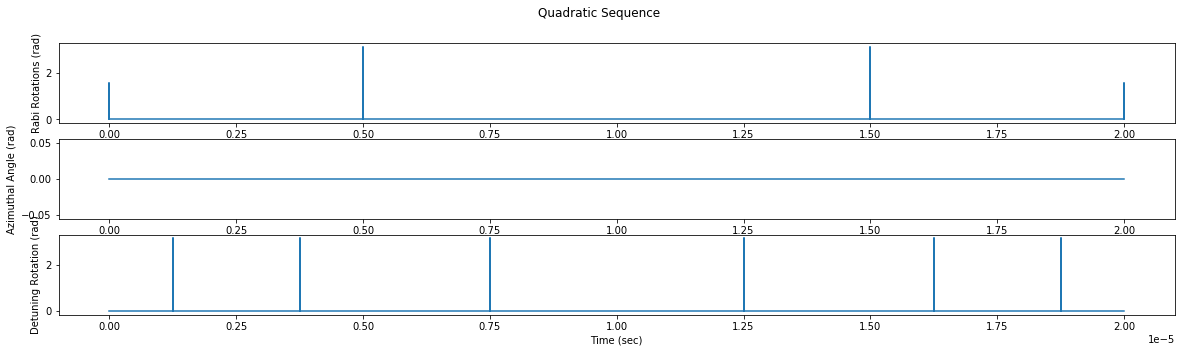

In [4]:
formatted_plot_data = quadratic_sequence.get_plot_formatted_arrays()
rabi_rotations, azimuthal_angles, detuning_rotations, times = (
    formatted_plot_data['rabi_rotations'],
    formatted_plot_data['azimuthal_angles'],
    formatted_plot_data['detuning_rotations'],
    formatted_plot_data['times']
)

# prepare the axes
figure, (rabi_plot_axis, azimuth_plot_axis, detuning_plot_axis) = plt.subplots(
    3, 1, figsize=(20,5))

rabi_plot_axis.plot(times, rabi_rotations)
rabi_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
rabi_plot_axis.set_xlabel('Time (sec)')
rabi_plot_axis.set_ylabel('Rabi Rotations (rad)')

azimuth_plot_axis.plot(times, azimuthal_angles)
azimuth_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
azimuth_plot_axis.set_xlabel('Time (sec)')
azimuth_plot_axis.set_ylabel('Azimuthal Angle (rad)')

detuning_plot_axis.plot(times, detuning_rotations)
detuning_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
detuning_plot_axis.set_xlabel('Time (sec)')
detuning_plot_axis.set_ylabel('Detuning Rotation (rad)')

plt.suptitle('Quadratic Sequence')
plt.show()

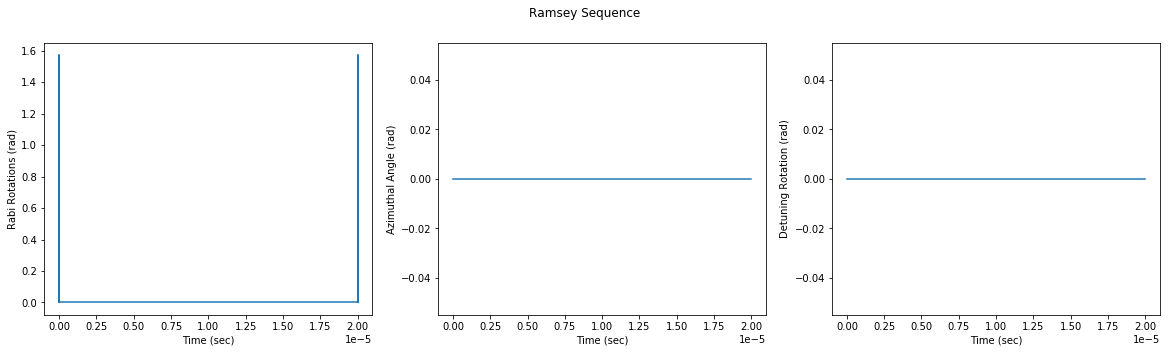

In [5]:
formatted_plot_data = ramsey_sequence.get_plot_formatted_arrays()
rabi_rotations, azimuthal_angles, detuning_rotations, times = (
    formatted_plot_data['rabi_rotations'],
    formatted_plot_data['azimuthal_angles'],
    formatted_plot_data['detuning_rotations'],
    formatted_plot_data['times']
)

# prepare the axes
figure, (rabi_plot_axis, azimuth_plot_axis, detuning_plot_axis) = plt.subplots(
    1, 3, figsize=(20,5))

rabi_plot_axis.plot(times, rabi_rotations)
rabi_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
rabi_plot_axis.set_xlabel('Time (sec)')
rabi_plot_axis.set_ylabel('Rabi Rotations (rad)')

azimuth_plot_axis.plot(times, azimuthal_angles)
azimuth_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
azimuth_plot_axis.set_xlabel('Time (sec)')
azimuth_plot_axis.set_ylabel('Azimuthal Angle (rad)')

detuning_plot_axis.plot(times, detuning_rotations)
detuning_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
detuning_plot_axis.set_xlabel('Time (sec)')
detuning_plot_axis.set_ylabel('Detuning Rotation (rad)')

plt.suptitle('Ramsey Sequence')
plt.show()

### Drawing the Circuits

We can use Qiskit to draw the circuits generated by Q-CTRL Open Controls.

#### Drawing the Quadratic DDS Circuit

Note that both DDS will be applied with $X_{\pi/2}$ rotations at beginning and end, that is, at offsets of $[0, 20]$ $\mu$s, to create the desired superposition state. The $X_{\pi/2}$ rotations are added to the circuits in the form of pre-post-gates that are implemented via Qiskit's $U3(\pi/2, -\pi/2, \pi/2)$ gate.

The $U1(\pi)$ gates are $Z_\pi$ pulses (a $\pi$ rotation around $Z$-axis) and $U3(\pi, -\pi/2, \pi/2)$ gates correspond to $X_{\pi}$ pulses (a $\pi$ rotation around $X$-axis). The gates match the pulses in the DDS.

The `Id` in the drawing corresponds to the `identity` gate. In the DDS, the first $Z_{\pi}$-pulse is applied at a delay of $1.25$ $\mu$s. This is approximated by introducing 3-`Id` gates with a delay of $0.4\times 3=1.2$ $\mu$s. Similarly, the second set of 6 `Id` gates introduces a delay of $2.4$ $\mu$s close to the actual delay of $3.75-1.25=2.50$ microseconds.

The `barrier` gates are special gates that tell the Qiskit compilers not to simplify a circuit at the specified positions.

At the end of each circuit, we place a `measurement` operator to read out the result.

In [6]:
##Drawing the Quadratic Circuit
quadratic_quantum_circuit.draw()

#### Drawing the Ramsey DDS Circuit

The drawing below shows the Ramsey DDS circuit consists of `Id` or `identity` gates surrounded by $X_{\pi/2}$-pulses on both ends. The `measurement` operator appears at the end as in the original definition of the circuit. This will help us run the circuit in one of the simulators.

In [7]:
ramsey_quantum_circuit.draw()

And here we count 50 `Id` operations, implementing a total delay of $50 \times 0.4 = 20 \mu s$

In [8]:
print(ramsey_quantum_circuit.count_ops()['id'])

50


### Run the Circuit on Qiskit Simulator using Qiskit API

Before running our circuits on the real IBM Q hardware, let's run them through a simulator first.

Consult [Simulating Circuits using Qiskit Aer](https://qiskit.org/documentation/getting_started.html#simulating-circuits-using-qiskit-aer) for a description of available simulators and their respective properties.

Here, we will use the `qasm-simulator` to run the circuit. The experiment consists of `number_of_shots` repeats of the circuit operations on a qubit. Each run collects the state of the qubit as measurement. The result is displayed as a histogram.

In [9]:
## Prepares the simulator backend
'''
backend : str
    One of 'unitary_simulator', 'statevector_simulator' or 'qasm_simulator';
    defaults to 'qasm_simulator'
'''
backend = 'qasm_simulator'
backend_simulator = BasicAer.get_backend(backend)

'''
number_of_shots : int
    Number of repeats the experiment has to be carried out;
    defaults to 1
'''
number_of_shots = 1024

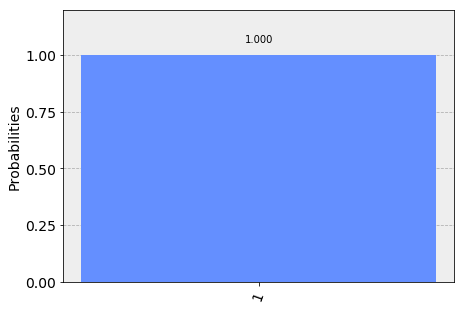

In [10]:
## Run the quadratic sequence circuit, Get the result (counts of state |1> and |0>), plot the histogram
job = execute(quadratic_quantum_circuit, backend_simulator, shots=number_of_shots)
result = job.result()
counts = result.get_counts(quadratic_quantum_circuit)
plot_histogram(counts)

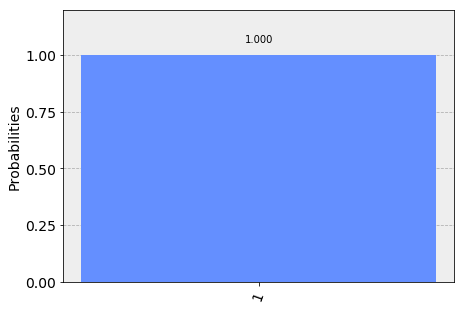

In [11]:
## Run the ramsey sequence circuit, Get the result (counts of state |1> and |0>), plot the histogram
job = execute(ramsey_quantum_circuit, backend_simulator, shots=number_of_shots)
result = job.result()
counts = result.get_counts(ramsey_quantum_circuit)
plot_histogram(counts)

## Running a Dynamical Decoupling Sequence on a Real Device

Now that we've verified that our circuits run on the simulators, let's take a look at what happens when we run them on the real IBM Q devices.

We use the same DDS and circuit defined above and use Qiskit's APIs to run the circuit. See [Running Circuits on IBM Q Devices](https://qiskit.org/documentation/getting_started.html#running-circuits-on-ibm-q-devices) for a more detailed explanation of the APIs used here.

### Select a Suitable Device Based on Account Type and Configuration Using Qiskit API

We use a basic configuration and choose the least busy device.

In [12]:
# NBVAL_SKIP
'''
account_token : str
    Token to enable IBM Q device access
'''
account_token = 'insert-your-ibmq-token-here'
IBMQ.enable_account(account_token)
available_devices = IBMQ.backends(
    filters=lambda x: not x.configuration().simulator and x.status().operational is True
)
#print(available_devices)
backend = least_busy(available_devices)
print('Least busy device is {}'.format(backend.name()))

Least busy device is ibmqx2


### Run the Circuits on a Real Device Using Qiskit API

Job Status: job has successfully run


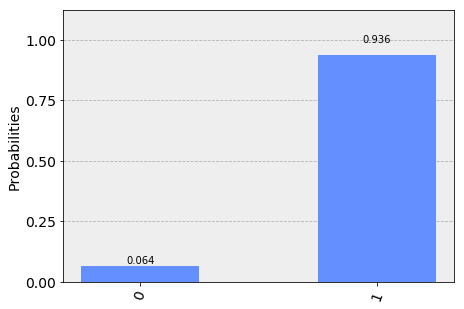

In [14]:
# NBVAL_SKIP
'''
number_of_shots : int
    Number of repeats the experiment has to be carried out;
    defaults to 1
'''
number_of_shots = 1024

# Run on a device
job = execute(quadratic_quantum_circuit, backend, shots=number_of_shots)
job_monitor(job)
result = job.result()
counts = result.get_counts(quadratic_quantum_circuit)
plot_histogram(counts)

Job Status: job has successfully run


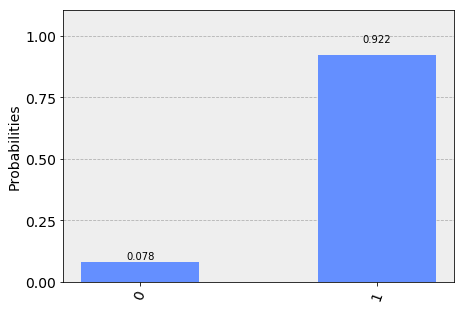

In [15]:
# NBVAL_SKIP
'''
number_of_shots : int
    Number of repeats the experiment has to be carried out;
    defaults to 1
'''
number_of_shots = 1024

# Run on a device
job = execute(ramsey_quantum_circuit, backend, shots=number_of_shots)
job_monitor(job)
result = job.result()
counts = result.get_counts(ramsey_quantum_circuit)
plot_histogram(counts)

### Close the Account

Just to make sure, close the account after the task is over.

In [16]:
# NBVAL_SKIP
IBMQ.disable_accounts(token=account_token)

## Reducing Errors by Increasing the Coherence Time

In the ideal noiseless simulator, both the Ramsey DDS and Quadratic DDS produced exactly the same outcome, the $|1 \rangle$ state with probability 1. However, in a real device, we can see a marked difference. The Quadratic DDS produced a probability distribution closer to the expected outcome. This is because the Quadratic DDS is able to cancel the effects of magnetic noise in the environment - extending the [T2 time](https://en.wikipedia.org/wiki/Spin–spin_relaxation), and effectively increasing the coherence of the qubit.